# Time-Evolution of Quantum Density Matrices in Conjugated Systems: 2-Level, Time-Independent Case

## Table of Contents

1. [Parameters](#1.-Parameters)

  - [Hamiltonian](#Hamiltonian)
  - [Initial Condition](#Initial-Condition)
  - [Numerical Solver](#Numerical-Solver)
  - [Plotting](#Plotting)

2. [Derived Parameters](#2.-Derived-Parameters)

3. [Tool Functions](#3.-Tool-Functions)

4. [Diagonalized Solution for Unperturbed Part](#4.-Diagonalized-Solution-for-Unperturbed-Part)

5. [Numerical Solution](#5.-Numerical-Solution)

6. [Plot](#6.-Plot)


In [1]:
%matplotlib notebook
from IPython.display import display
import numpy as np
import numpy.linalg as lg
from scipy.integrate import ode
import matplotlib.pyplot as plt

## 1. Parameters

### Hamiltonian

In [2]:
# Two-level system, same energy level, time-periodic, numerical
#
#   d   [rho11 rho12]       i      [a'  b']    [rho11 rho12]
#  ---- [rho21 rho22] = - ------ [ [b'  a']  , [rho21 rho22] ]  
#   dt                    h_bar
#
#  where time periodic term parameters:
#
#     * frequency w
#     * phase angle φ=0
#
#  
#  H = [a'  b'] = [a  b]  +  [a_em  b_em] sin(wt+φ)
#      [b'  a']   [b  a]     [b_em  a_em]
#
#
#   let (A, B, A_em, B_em) = (a, b, a_em, b_em) / h_bar
#   (or simply use atomic unit where h_bar = 1)
#
#       [rho11]        [  0   -B'   B'  0 ]  [rho11]
#   d   [rho12]        [ -B'   0    0   B']  [rho12]
#  ---- [rho21]  = -i  [  B'   0    0  -B']  [rho21]
#   dt  [rho22]        [  0    B'  -B'  0 ]  [rho22]
#
#
#  B' = B + B_em * sin(wt+φ)
#     where B_em is external electromagnetic field

# Unperturbed Hamiltonian
A = -0.2  # typical alpha = -27.2eV * 0.2 = -5.44eV (unimportant now...)
dA = -A*0.50  # energy raise at the second atom
B = -0.1  # typical beta = -27.2eV * 0.1 = -2.72 eV
          #     NOTE: "Natural" Angular Frequency of the molecule
          #           is 2*|B| 
H0 = np.matrix([[A, B   ],
                [B, A+dA]])

# Electromagnetic Hamiltonian
A_em = 0.0  # Non-polar molecule = 0
B_em = -0.00  # Typical aromatic IR absorption = 1600 cm-1 = 7.3e-3 Hartree
              # (too weak compared to B)
H_em = np.matrix([[A_em, B_em],
                  [B_em, A_em]])

w_em = 10 * (2*abs(B))  
  # Angular freq.: 1600 cm-1  ->  T = 20.85fs = 868.75 (a.u.)
  #     w_em = 2*pi / T = 7.2e-3 But also too slow...
psi0_em = 0.0  # initial phase angle

### Initial Condition

In [3]:
# time
ti = 0.0

# state ( rho0 = |phi0> <phi0| )
phi0_unnormalized = np.array([1, 0])

### Numerical Solver

In [4]:
integration_method = "zvode"  # Adams-Bashforth-based, 4th order.

### Plotting

In [5]:
# tf (here we set to "periods to plot" because we know 
#     the natural frequency of the unperturbed system)
n_period = 10
tf = n_period * (2 * np.pi) / ( 2 * abs(B))

# points to plot, including both endpoints
pts = 1 + 30000

## 2. Derived Parameters

In [6]:
# number of levels
N_H = H0.shape[0]  # .shape returns (N, N) for an N*N matrix
assert(H0.shape[0] == H0.shape[1])

# I.C.
phi0 = phi0_unnormalized / lg.norm(phi0_unnormalized)
rho0 = np.tensordot(phi0, phi0, axes=0)
rho0_vec = rho0.reshape(N_H*N_H, )

# points to plot
t_lin = np.linspace(ti, tf, pts)
assert np.size(t_lin) == pts
# step length
dt_lin = t_lin[1:pts] - t_lin[0:pts-1]  # (1 ~ pts-1) - (0 ~ pts-2)
assert np.size(dt_lin) == pts - 1


def rhodot_vec(t, rho_vec, N_H, H0, H_em, w_em, psi0_em):
    ''' Quantum Master Equation '''

    # reshape to matrix before calculation
    rho = rho_vec.reshape(N_H, N_H)
    
    # calculate commutator
    H = H0 + np.sin(w_em*t + psi0_em) * H_em
    rhodot =  (-1j) * (np.dot(H, rho) - np.dot(rho, H))

    # cast to vector
    return rhodot.reshape(N_H*N_H, )


## 3. Tool Functions

In [7]:
# convert y[i] to rho[m,n] functions 
def i_to_mn(i):
    m = np.floor(i / N_H) 
    n = np.floor(i % N_H)
    return int(m), int(n)

assert i_to_mn(2) == (1, 0)

# convert rho[m,n] to y[i]
def mn_to_i(m, n):
    return m * N_H + n

assert mn_to_i(1, 1) == 3

In [8]:
# Plotting
def plot_rhohat_vec(i):
    '''plot rhohat_vec[i]'''
    
    fig = plt.figure(figsize=(8, 5), dpi=100)  # No vector format, set manually
    ax = fig.add_subplot(111)

    t = t_lin
    y = rhohat_vec[i,:]

    ax.plot(t, np.absolute(y), color="green", label="rho")
    # may add , marker="o", markersize=2
    # ax.plot(t, np.imag(y), color="green", label="im")
    ax.set_xlabel("t (2.42e-17s)", fontsize=14, color="#808080")
    ax.tick_params(axis="x", labelcolor="#808080")
    ax.set_ylabel("|y|", fontsize=14, color="#808080")
    ax.set_ylim([-0.05, 1.05])
    ax.tick_params(axis="y", labelcolor="#808080")
    ax.xaxis.get_offset_text().set_color("#808080")
    ax.yaxis.get_offset_text().set_color("#808080")
    ax.grid()
    #ax.legend()
    
    # title
    m, n = i_to_mn(i)
    ttl = "y[{0}] = rho[{1}, {2}]".format(i, m, n)
    fig.suptitle(ttl, fontsize=16, color="#3333ff")
    
    fig.show()
    

def plot_rhohat(m, n):
    """ index wrapper """
    i = mn_to_i(m, n)
    plot_rhohat_vec(i)

## 4. Diagonalized Solution for Unperturbed Part

In [9]:
e0, MO0 = lg.eigh(H0)

In [10]:
e0

array([-0.2618034, -0.0381966])

In [11]:
MO0

matrix([[-0.85065081,  0.52573111],
        [-0.52573111, -0.85065081]])

## 5. Numerical Solution

In [12]:
# initialize
solver = ode(rhodot_vec).set_integrator(integration_method)
solver.set_initial_value(rho0_vec, ti).set_f_params(N_H, H0, H_em, w_em, psi0_em)

# answer vector
rhohat_vec = np.zeros((N_H*N_H, pts), 'complex128')
rhohat_vec[:,0] = rho0_vec
assert rhohat_vec[0,0] == rho0_vec[0]
assert rhohat_vec[1,0] == rho0_vec[1]
assert rhohat_vec[2,0] == rho0_vec[2]
assert rhohat_vec[3,0] == rho0_vec[3]


In [13]:
# do
for i in range(pts - 1):
    
    try:
        solver.integrate(solver.t + dt_lin[i])
        rhohat_vec[:, i+1] = solver.y
    except Exception as e:
        display(e)
        raise e
    
    if not solver.successful():
        raise ValueError("[Error] ode solver unsuccessful!")

    #display("solver.y = " + str(solver.y))
    #display("solver.t = " + str(solver.t))
    

## 6. Plot

<IPython.core.display.Javascript object>


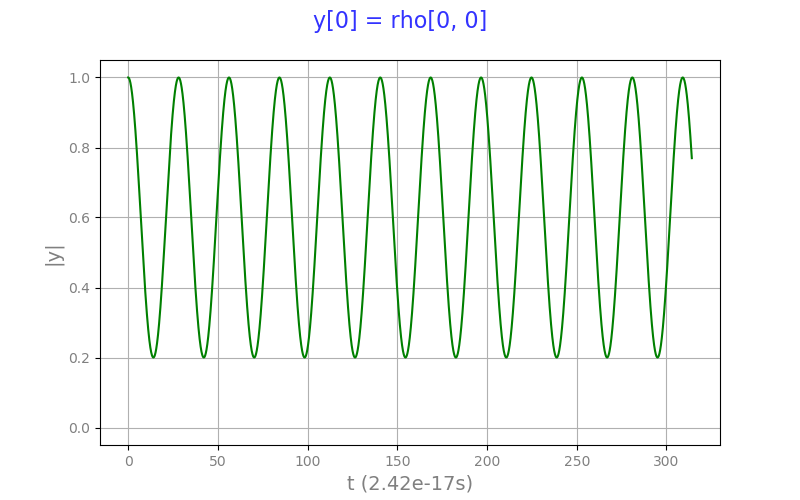

In [14]:
# rho00
plot_rhohat(0, 0)

<IPython.core.display.Javascript object>


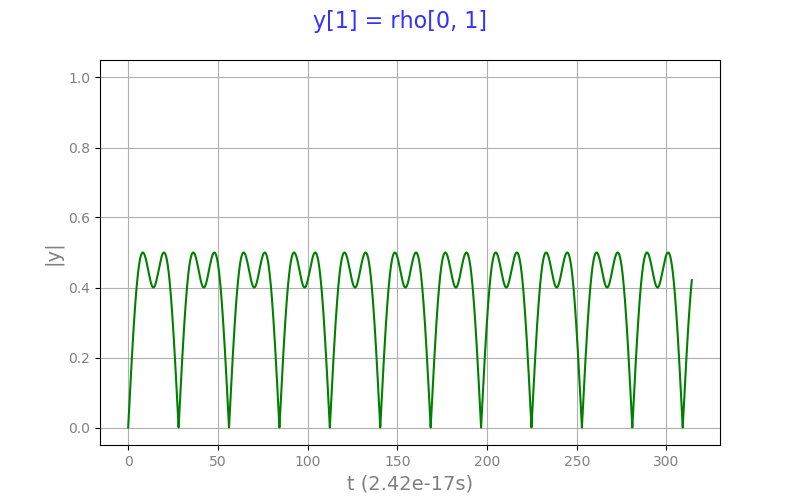

In [15]:
# rho01
plot_rhohat(0, 1)

<IPython.core.display.Javascript object>


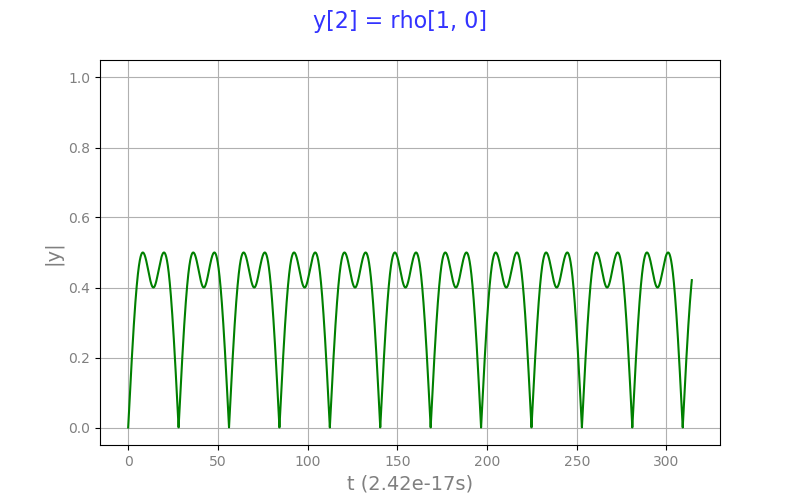

In [16]:
# rho10
plot_rhohat(1, 0)

<IPython.core.display.Javascript object>


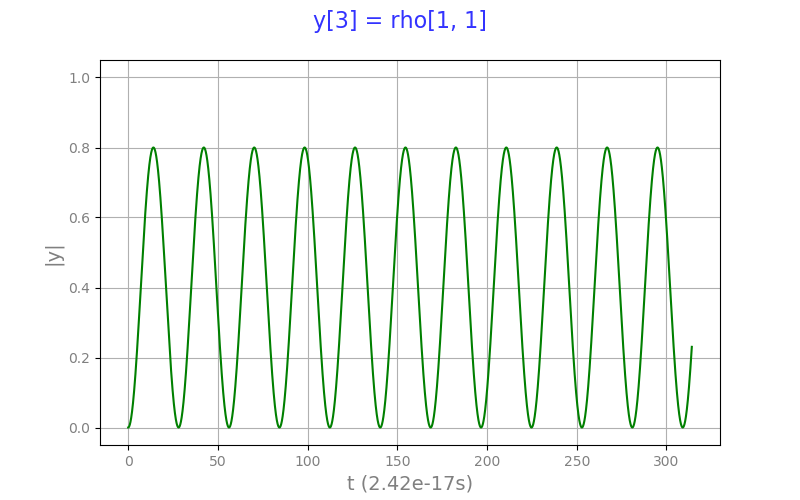

In [17]:
# rho11
plot_rhohat(1, 1)